<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/From_AODB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Antioxidants Data Curation (Data from AODB)

In [4]:
#get functions from functions file (still have to move most of the functions there!)
!wget https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py

from func import is_substruct_in, convert_smiles_series_to_fp_to_np_array

#Import packages
!pip install rdkit
import pandas as pd
import re
import numpy as np
import os
from google.colab import drive
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
import matplotlib.pyplot as plt
import math
from sklearn.manifold import TSNE
RDLogger.DisableLog("rdApp.info")

--2025-04-15 10:12:35--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master/func.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py [following]
--2025-04-15 10:12:35--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4857 (4.7K) [text/plain]
Saving to: ‘func.py.3’

func.py.3           100%[===================>]   4.74K  --.-KB/s    in 0s      

2025-04-15 10:12:35 (29.7 MB/s) - ‘func.py.3’ saved [4857/4857]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
#Get data export from AODB by adding it (locally) or in drive (colab needs to be connected to drive)
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/AODB_antio_compounds.csv" #https://drive.google.com/file/d/1oc3pU4BPqn1T-Rta9qZtYNfypGgWt3XH/view?usp=sharing to get acces to csv
dataset_initial = pd.read_csv(file_path)

#if first converted to xlsx
#file_path = "/content/drive/MyDrive/Colab Notebooks/AODB_antio_compounds.xlsx"
#dataset_initial = pd.read_excel(file_path)

# Print the first 5 rows of the dataset
dataset_initial.head()

Mounted at /content/drive


,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,...,Hepatotoxic Prediction,Hepatotoxic Applicability,Hepatotoxic Applicability MD,Hepatotoxic Applicability MDpvalue,Absorption Level,PPB,PPB Prediction,PPB Applicability,PPB Applicability MD,PPB Applicability MDpvalue
0,AOXMO00001,COc1ccc(C2C=C(c3cccc4ccccc34)Nc3nncn32)cc1,InChI=1S/C22H18N4O/c1-27-17-11-9-16(10-12-17)2...,C22H18N4O,354.4,4.5,1,5.0,52.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Unknown SCFP_2 feature: 1390187696: [*]N1[*][*...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown SCFP_2 feature: 864870584: [*]C=C(N=[*...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Unknown SCFP_2 feature: 312311691: [*]N([*])C(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Unknown SCFP_2 feature: -1265366654: [*]N=C1N[...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Filtering

In [7]:
print(len(df_AODB_all))
print(dataset_initial.columns)

#Filter Data rows for data curation (determined by inspection of data)
df_dpph = df_AODB_all[df_AODB_all["Assay Description"].str.contains("DPPH", case=False, na=False) &
          df_AODB_all["Experimental Data"].str.contains("IC50|EC50", case=False, na=False)
      & ~df_AODB_all["Experimental Data"].str.contains("relative|1/IC50|1/EC50|ratio", case=False, na=False)
      & ~df_AODB_all["Activity Comment"].str.contains("Dose dependent data|Not determined", case=False, na=False)
      & ~df_AODB_all["Target Organism"].str.contains("Rattus norvegicus", case=False, na=False)
      & ~df_AODB_all["Assay Description"].str.contains("liposome|relative|ratio|rat brain", case=False, na=False)
      & (df_AODB_all["Molecular Weight"] <= 1000)  # filter only small MW compounds
]
print(len(df_dpph))
#Reset index
df_dpph.reset_index(drop=True, inplace=True)

484181
Index(['AOX ID', 'SMILES', 'InChI', 'Molecular Formula', 'Molecular Weight',
       'AlogP', 'HBD', 'HBA', 'Polar Surface Area', 'Rotatable Bonds',
       'QED Weighted', 'Chiral Center', 'Aromatic Rings', 'Heavy Atoms',
       'PubChem CID', 'PubChem AID', 'ChEMBL ID', 'NCBI:txid', 'NCBI Gene ID',
       'Protein Target ID', 'PMID', 'DOI', 'Assay Description', 'Source',
       'Assay Type', 'Activity Comment', 'Target Organism',
       'Protein Target Name', 'Standard Deviation', 'Assay Description ',
       'Average Activation at 10.6 uM, %', 'Kd, uM', 'Inhibition at 50 uM , %',
       'Inhibition at 5 uM , % ', 'Activation at 10.6 uM, %',
       'Relative transcription levels at 1uM, %', 'Percent Response, %',
       'Phenotype', 'Potency', 'Efficacy', 'Phenotype-Replicate_1',
       'Potency-Replicate_1', 'Efficacy-Replicate_1', 'Experimental Data',
       'Target ChEMBL ID', 'Target Pref Name', 'Cell Line Target',
       'Solubility', 'Solubility Level', 'AlogP98', 'PSA 2D'

## Canonicalize and Standardize SMILES

In [8]:
#standardize and canonicalize smiles and add new column canonical_Smiles (may have to still check if this is enough or more standardization needed?)
df_dpph["canonical_Smiles"] = df_dpph["SMILES"].apply(rdMolStandardize.StandardizeSmiles)

<ipython-input-8-ad8de1534fd6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dpph["canonical_Smiles"] = df_dpph["SMILES"].apply(rdMolStandardize.StandardizeSmiles)


## Convert Activity values (problems if run multiple times)

In [9]:
# Function to parse the Experimental Data column
def parse_experimental_data(row):
    # Use regex to extract components
    match = re.match(r'(IC50|EC50)\s*(>=|>|=)\s*([\d.]+)\s*(nM|ug\.mL-1|µg\.mL-1)', row)
    if match:
        return {
            'activity_type': match.group(1),
            'operator': match.group(2),
            'activity_value': float(match.group(3)),
            'units': match.group(4).replace('.', '')  # Remove dots (e.g., ug.mL-1 -> ugmL-1)
        }
    else:
        return None

# Apply parsing and expand into new columns
parsed_data = df_dpph['Experimental Data'].apply(parse_experimental_data).apply(pd.Series)

# Combine with original DataFrame
df_dpph = pd.concat([df_dpph, parsed_data], axis=1)

# Display results
df_dpph.head()

,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,...,PPB,PPB Prediction,PPB Applicability,PPB Applicability MD,PPB Applicability MDpvalue,canonical_Smiles,activity_type,operator,activity_value,units
0,AOXMO00050,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,InChI=1S/C18H15NO3/c20-9-19-6-5-12-8-15-18(22-...,C18H15NO3,293.3,2.69,0,4.0,38.8,1.0,...,NaN,NaN,NaN,NaN,NaN,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,IC50,=,121400.0,nM
1,AOXMO00051,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,C6H8O6,176.1,-1.41,4,6.0,107.2,2.0,...,NaN,NaN,NaN,NaN,NaN,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,IC50,=,52100.0,nM
2,AOXMO00487,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H17N3O/c1-14-17(19-13-15-9-5-3-6-1...,C18H17N3O,291.4,3.24,0,4.0,39.3,3.0,...,NaN,NaN,NaN,NaN,NaN,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31260.0,nM
3,AOXMO00488,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H16ClN3O/c1-13-17(20-12-14-8-10-15...,C18H16ClN3O,325.8,3.89,0,4.0,39.3,3.0,...,NaN,NaN,NaN,NaN,NaN,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31680.0,nM
4,AOXMO00489,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C20H22N4O/c1-15-19(21-14-16-10-12-17(...,C20H22N4O,334.4,3.3,0,5.0,42.5,4.0,...,NaN,NaN,NaN,NaN,NaN,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,2430.0,nM


In [10]:
#convert units of ugmL-1 activity values in nM
def convert_units(row):
    """Proper unit conversion with consistent numeric output"""
    # Check if conversion is needed and possible
    if (row['units'] == 'ugmL-1' and
        'Molecular Weight' in row and
        not pd.isna(row['Molecular Weight']) and
        not pd.isna(row['activity_value'])):

        # Convert µg/mL to nM: (µg/mL * 10^6) / (g/mol) = nM
        return round((float(row['activity_value']) * 10**6) / float(row['Molecular Weight']))

    # Return original value if already in nM or no conversion possible
    elif row['units'] == 'nM' and not pd.isna(row['activity_value']):
        return float(row['activity_value'])

    # Return NaN for unconvertable cases
    return np.nan

# Apply conversion and force float dtype
df_dpph['value_nM'] = df_dpph.apply(convert_units, axis=1).astype(float)

In [11]:
#check if ugmL-1 were properly converted
print(df_dpph[df_dpph['units']=='ugmL-1'])

          AOX ID                                             SMILES  \
18    AOXMO00508                 Cc1n[nH]c(=O)n1/N=C/c1ccc(O)c(O)c1   
19    AOXMO00509         O=c1[nH]nc(Cc2ccccc2)n1/N=C/c1ccc(O)c(O)c1   
20    AOXMO00510     O=c1[nH]nc(Cc2ccc(Cl)cc2)n1/N=C/c1ccc(O)c(O)c1   
21    AOXMO00511     COc1ccc(Cc2n[nH]c(=O)n2/N=C/c2ccc(O)c(O)c2)cc1   
22    AOXMO00512         O=c1[nH]nc(-c2ccccc2)n1/N=C/c1ccc(O)c(O)c1   
...          ...                                                ...   
4708  AOXMO44737  Cc1ccc2c3c([nH]c2c1)C1=C(C#N)C(=O)NC1(C1C(=O)N...   
4709  AOXMO44738                    O=C1O[C@H]([C@@H](O)CO)C(O)=C1O   
4812  AOXMO46263  CCOC(=O)c1cc2ccc(OCc3cn(Cc4ccc([N+](=O)[O-])cc...   
4813  AOXMO46264                   Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1   
4865  AOXMO46434             Cc1ccc(C(=O)CC(=O)c2cc3ccccc3s2)c(O)c1   

                                                  InChI Molecular Formula  \
18    InChI=1S/C10H10N4O3/c1-6-12-13-10(17)14(6)11-5...        C10H10N

In [12]:
#Convert IC50 values in nM into pIC50 values
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

# Apply conversion to each row of the compounds DataFrame
df_dpph["pIC50"] = df_dpph.apply(lambda x: convert_ic50_to_pic50(x.value_nM), axis=1)
df_dpph.head()

,AOX ID,SMILES,InChI,Molecular Formula,Molecular Weight,AlogP,HBD,HBA,Polar Surface Area,Rotatable Bonds,...,PPB Applicability,PPB Applicability MD,PPB Applicability MDpvalue,canonical_Smiles,activity_type,operator,activity_value,units,value_nM,pIC50
0,AOXMO00050,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,InChI=1S/C18H15NO3/c20-9-19-6-5-12-8-15-18(22-...,C18H15NO3,293.3,2.69,0,4.0,38.8,1.0,...,NaN,NaN,NaN,O=CN1CCc2cc3c(c4c2[C@H]1Cc1ccccc1-4)OCO3,IC50,=,121400.0,nM,121400.0,3.915781
1,AOXMO00051,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,C6H8O6,176.1,-1.41,4,6.0,107.2,2.0,...,NaN,NaN,NaN,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,IC50,=,52100.0,nM,52100.0,4.283162
2,AOXMO00487,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H17N3O/c1-14-17(19-13-15-9-5-3-6-1...,C18H17N3O,291.4,3.24,0,4.0,39.3,3.0,...,NaN,NaN,NaN,Cc1c(/N=C/c2ccccc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31260.0,nM,31260.0,4.505011
3,AOXMO00488,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C18H16ClN3O/c1-13-17(20-12-14-8-10-15...,C18H16ClN3O,325.8,3.89,0,4.0,39.3,3.0,...,NaN,NaN,NaN,Cc1c(/N=C/c2ccc(Cl)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,31680.0,nM,31680.0,4.499215
4,AOXMO00489,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,InChI=1S/C20H22N4O/c1-15-19(21-14-16-10-12-17(...,C20H22N4O,334.4,3.3,0,5.0,42.5,4.0,...,NaN,NaN,NaN,Cc1c(/N=C/c2ccc(N(C)C)cc2)c(=O)n(-c2ccccc2)n1C,IC50,=,2430.0,nM,2430.0,5.614394


## Visual inspection of data

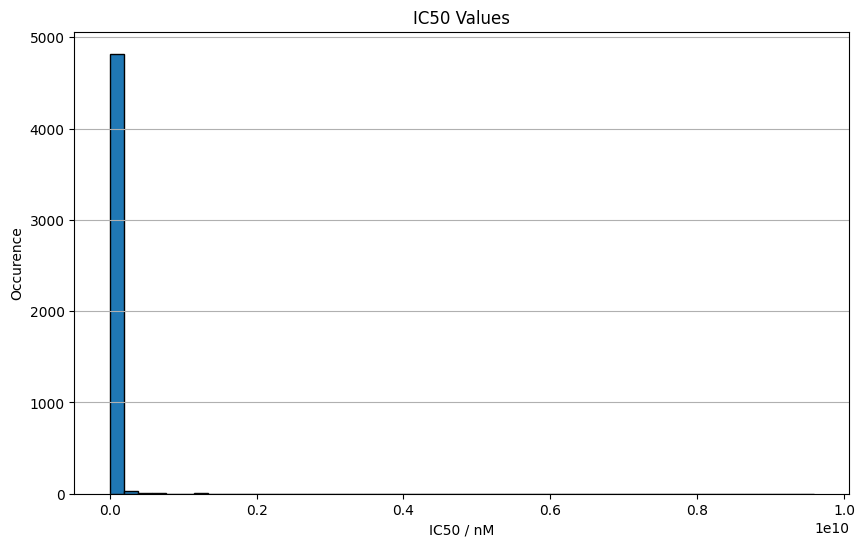

In [13]:
# Histogram of IC50 values in nM
plt.figure(figsize=(10, 6))
plt.hist(df_dpph['value_nM'], bins=50, edgecolor='black')
plt.title('IC50 Values')
plt.xlabel('IC50 / nM')
plt.ylabel('Occurence')
plt.grid(axis='y')

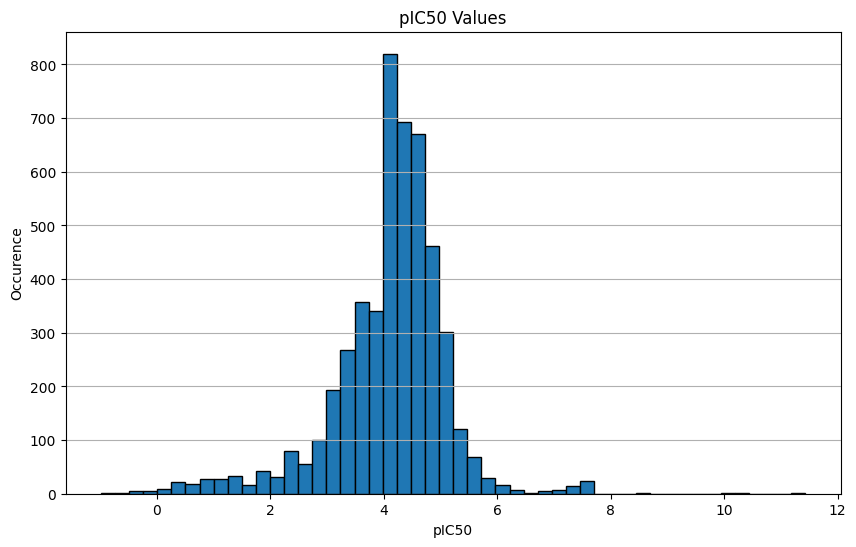

In [14]:
# Histogram of pIC50 values
plt.figure(figsize=(10, 6))
plt.hist(df_dpph['pIC50'], bins=50, edgecolor='black')
plt.title('pIC50 Values')
plt.xlabel('pIC50')
plt.ylabel('Occurence')
plt.grid(axis='y')

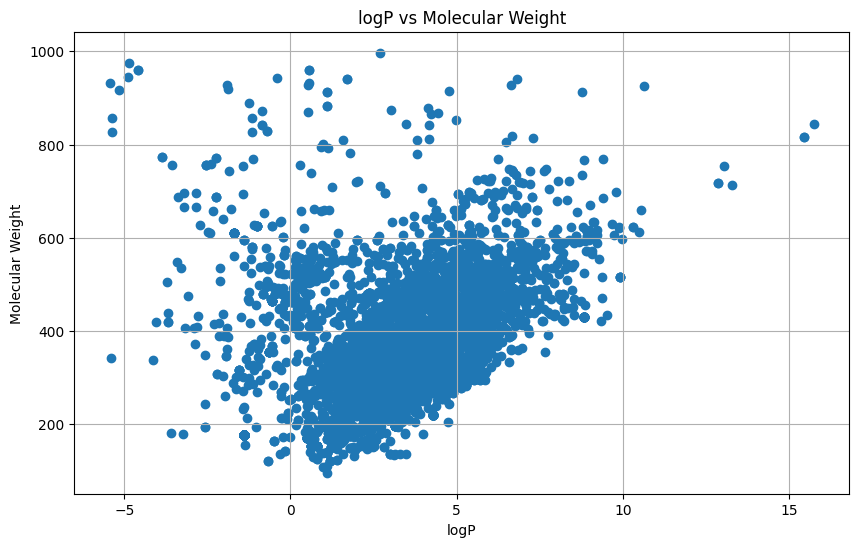

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['AlogP'], df_dpph['Molecular Weight'])
plt.title('logP vs Molecular Weight')
plt.xlabel('logP')
plt.ylabel('Molecular Weight')
plt.grid(True)

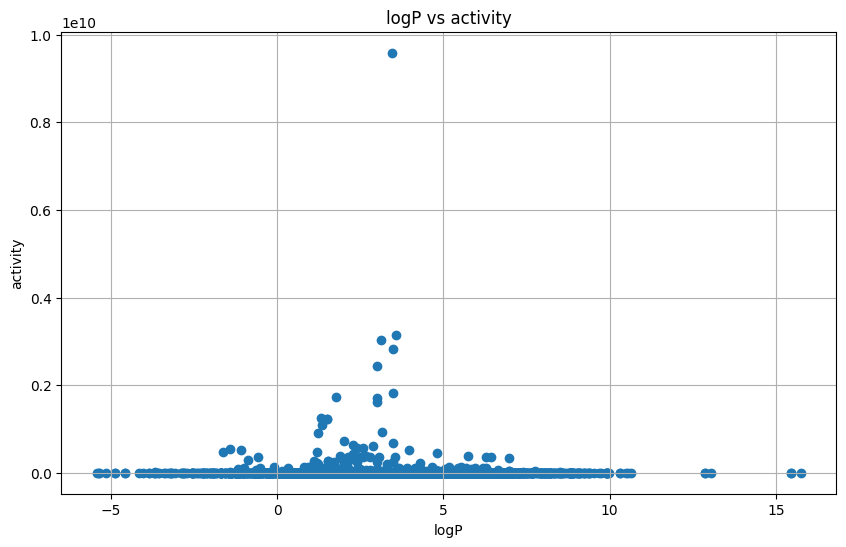

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['AlogP'], df_dpph['value_nM'])
plt.title('logP vs activity')
plt.xlabel('logP')
plt.ylabel('activity')
plt.grid(True)

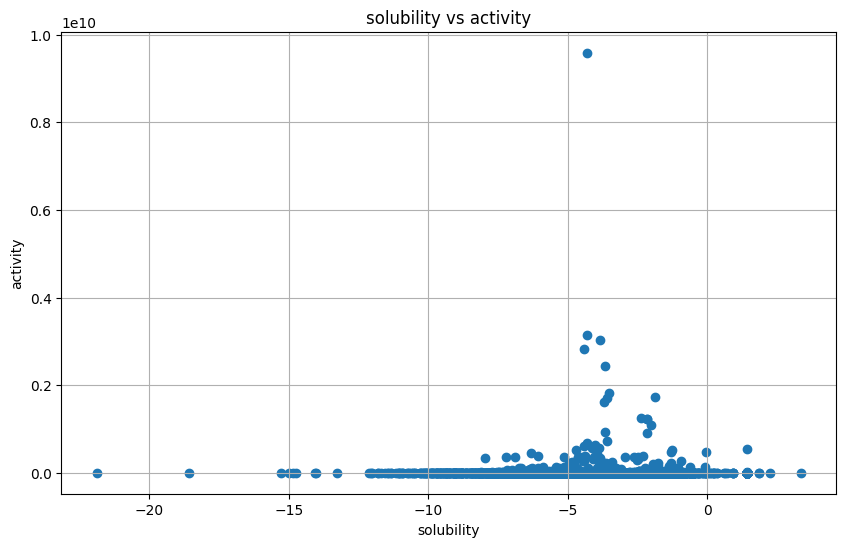

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(df_dpph['Solubility'], df_dpph['value_nM'])
plt.title('solubility vs activity')
plt.xlabel('solubility')
plt.ylabel('activity')
plt.grid(True)

## Other Data Inspection

In [18]:
#inspect high activity value compounds
print(df_dpph[df_dpph['value_nM']>1*10**9])

          AOX ID                                    SMILES  \
938   AOXMO09606                       O=C(O)/C=C/c1ccccc1   
959   AOXMO09627               O=c1cc(-c2ccccc2)oc2ccccc12   
970   AOXMO09638  O=C(/C=C/c1ccc([N+](=O)[O-])cc1)c1ccccc1   
971   AOXMO09639                O=C(/C=C/c1ccccc1)c1ccccc1   
1825  AOXMO17929            O=C(O)CCCc1nc2ccccc2c(=O)[nH]1   
1826  AOXMO17930                 O=C(O)CCc1nc(O)c2ccccc2n1   
2120  AOXMO19277                       O=c1ccc2ccc(O)cc2o1   
2121  AOXMO19278                       O=c1ccc2cc(O)ccc2o1   
2403  AOXMO22010                         CC1=CCC2CC1C2(C)C   
2404  AOXMO22011                       C=C1CCC2(C(C)C)CC12   
2405  AOXMO22012                         C=C1CCC2CC1C2(C)C   
2407  AOXMO22014                         C=CC(=C)CCC=C(C)C   
2409  AOXMO22016                          Cc1ccc(C(C)C)cc1   

                                                  InChI Molecular Formula  \
938   InChI=1S/C9H8O2/c10-9(11)7-6-8-4-2-1-3-5-8/h1-..

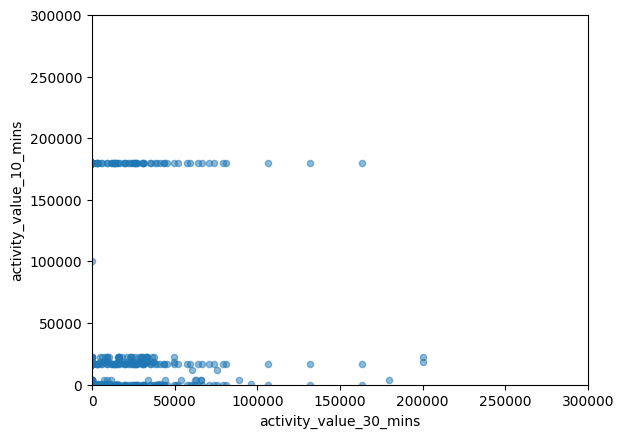

Index(['AOX ID', 'SMILES', 'InChI', 'Molecular Formula', 'Molecular Weight',
       'AlogP', 'HBD', 'HBA', 'Polar Surface Area', 'Rotatable Bonds',
       'QED Weighted', 'Chiral Center', 'Aromatic Rings', 'Heavy Atoms',
       'PubChem CID', 'PubChem AID', 'ChEMBL ID', 'NCBI:txid', 'NCBI Gene ID',
       'Protein Target ID', 'PMID', 'DOI', 'Assay Description', 'Source',
       'Assay Type', 'Activity Comment', 'Target Organism',
       'Protein Target Name', 'Standard Deviation', 'Assay Description ',
       'Average Activation at 10.6 uM, %', 'Kd, uM', 'Inhibition at 50 uM , %',
       'Inhibition at 5 uM , % ', 'Activation at 10.6 uM, %',
       'Relative transcription levels at 1uM, %', 'Percent Response, %',
       'Phenotype', 'Potency', 'Efficacy', 'Phenotype-Replicate_1',
       'Potency-Replicate_1', 'Efficacy-Replicate_1', 'Experimental Data',
       'Target ChEMBL ID', 'Target Pref Name', 'Cell Line Target',
       'Solubility', 'Solubility Level', 'AlogP98', 'PSA 2D', 'BBB'

In [19]:
#not sure but first 3 rows can probably be removed
#parsed_data = df_dpph['Experimental Data'].apply(parse_experimental_data).apply(pd.Series)
#df_dpph = pd.concat([df_dpph, parsed_data], axis=1)
#df_dpph["value_nM"] = df_dpph.apply(convert_units, axis = 1)

#inspect values for 10 min and 30 min assays
df_dpph_10_mins = df_dpph[df_dpph["Assay Description"].str.contains("10 mins", case=False, na=False)]
df_dpph_30_mins = df_dpph[df_dpph["Assay Description"].str.contains("30 mins", case=False, na=False)]



merged_df = pd.merge(df_dpph_30_mins, df_dpph_10_mins, on=["canonical_Smiles"], how="outer", suffixes=('_30_mins', '_10_mins'))

merged_df = merged_df.dropna(subset=["activity_value_30_mins", "activity_value_10_mins"], how="all")
merged_df[["activity_value_30_mins", "activity_value_10_mins"]].dropna().plot(kind="scatter", x="activity_value_30_mins", y="activity_value_10_mins", alpha=0.5)
plt.xlim([0, 300000])
plt.ylim([0, 300000])
plt.xlabel("activity_value_30_mins")
plt.ylabel("activity_value_10_mins")
plt.show()
df_dpph.columns


In [25]:
#check with phenol SMARTS if compounds are phenolic

phenol = "c1ccccc1[OH]"
df_dpph["is_phenol"] = df_dpph["canonical_Smiles"].apply(is_substruct_in, substruct_smarts = phenol)

print(len(df_dpph[df_dpph["is_phenol"] == True]), len(df_dpph))

fp_array = convert_smiles_series_to_fp_to_np_array(df_dpph["canonical_Smiles"])

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne.fit_transform(fp_array)

2956 5037


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use MorganGenerator
[10:29:26] DEPRECATION WARNING: please use Morga

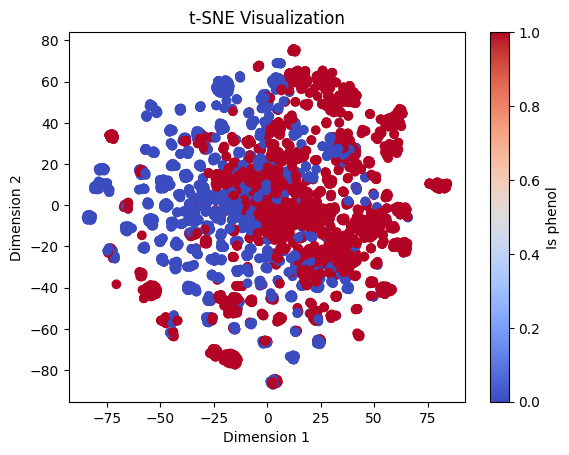

In [26]:
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=df_dpph["is_phenol"], cmap="coolwarm")
cb = plt.colorbar()
cb.set_label("Is phenol")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.title("t-SNE Visualization")
plt.show()

In [27]:
df_test = df_dpph[["canonical_Smiles", "activity_value"]]
df_dpph["DOI"].value_counts()

,count
DOI,
10.1016/j.bmcl.2012.12.001,91
10.1016/j.bmc.2014.10.015,50
10.1016/j.bmcl.2014.09.028,50
10.1016/j.ejmech.2010.04.013,39
10.1016/j.ejmech.2011.08.010,37
...,...
10.1016/j.bmcl.2012.12.060,1
10.1021/np030513u,1
10.1021/np500233t,1


In [28]:
df_dpph["Assay Description"].value_counts()

,count
Assay Description,
Antioxidant activity assessed as DPPH radical scavenging activity,507
Antioxidant activity assessed as DPPH radical scavenging activity after 30 mins,308
Antioxidant activity assessed as DPPH free radical scavenging activity after 30 mins,270
Antioxidant activity assessed as DPPH free radical scavenging activity,207
Antioxidant activity assessed as DPPH radical scavenging activity after 30 mins by spectrophotometry,156
...,...
Antioxidant activity assessed as DPPH free radical scavenging after 40 mins incubation in dark,1
Antioxidant activity assessed as DPPH radical scavenging activity incubated for 10 mins under dark condition,1
Antioxidant activity assessed as DPPH free radical scavenging after 20 mins by UV-Vis spectrophotometric analysis,1


In [29]:
df_dpph["canonical_Smiles"].value_counts()

,count
canonical_Smiles,
O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,168
Cc1c(C)c2c(c(C)c1O)CCC(C)(C(=O)O)O2,78
Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,57
Cc1c(C)c2c(c(C)c1O)CC[C@@](C)(CCC[C@H](C)CCC[C@H](C)CCCC(C)C)O2,40
O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,39
...,...
COc1cc(OC)c(OC)cc1/C=C/C(=O)c1cccc([N+](=O)[O-])c1,1
COc1cc(OC)c(OC)cc1/C=C/C(=O)c1ccc(Cl)cc1,1
COc1ccc(C(=O)/C=C/c2cc(OC)c(OC)cc2OC)cc1,1


## Save dataframe as csv to Github

In [ ]:
#still have to do

## Landrum et al. inspired data curation (10.1021/acs.jcim.4c00049)



In [30]:
df_model_1 = df_dpph["canonical_Smiles"].value_counts().reset_index()
repeated_smiles = df_model_1[df_model_1["count"] > 1]["canonical_Smiles"]
df_model_1 = df_dpph[df_dpph["canonical_Smiles"].isin(repeated_smiles)]

df_model_1_grouped = df_model_1.groupby(["canonical_Smiles"])["value_nM"].mean()
df_model_1_grouped.head()


,value_nM
canonical_Smiles,
C/C=C/c1ccc2oc(-c3ccc(O)cc3O)cc2c1,22100.000000
C/C=C/c1ccc2oc(-c3ccc(O)cc3OC)cc2c1,36300.000000
C/C=C/c1ccc2oc(-c3ccc(OC)cc3O)cc2c1,24200.000000
CC(=O)N[C@@H](CS)C(=O)O,46966.666667
CC(C)(C)c1cc(O)ccc1O,47626.000000


## 30 min assay duration data curation

## Minimal data curation